In [5]:
import numpy as np
from stable_baselines3 import PPO
import matplotlib.pyplot as plt
import random
import pandas as pd
import itertools

In [6]:
#DEFAULT_SPD = 20 #kts
#MAX_DISTANCE = 15 #nm
#MIN_DISTANCE = 5 #nm
#DEFAULT_FUEL = 48 #barrels
#DEFAULT_FUEL_CONSUMPTION_RATE = 24 # bph
#DISTANCE_TO_PORT = 20 #nm
#DEFAULT_RESCUE_ATTEMPTS_BASELINE = .0
#RESCUE_FUEL_CONSUMPTION_FACTOR = .1
#FUEL_CONSUMPTION_MAX_VARIATION = .05 #5%
# The intution here is that search costs more fuel (speed changes, zigzagging, etc.) and rescue magnitude cost is smaller but variation is much larger/less predictable
#SEARCH_FUEL_COST = 1
#TRANSIT_FUEL_COST = 0
#RESCUE_FUEL_COST = 10

#The Arleigh Burke class destroyers consume 24 barrels / hour ( 1000 gallons ) at 20 knots giving a range of 5334 kilometres.

# Relationships
#   FC = fuel consumed (b)
#   D = distance (nm)
#   FCR = Fuel consumption rate (bph)
#   S = speed (kts)
#
#   FC = FCR * D / S ( b/h * nm * h/nm = b)
#   D = FC * S / FCR ( b * nm/h * h/b = nm)

def man_overboard():
    return random.uniform(MIN_DISTANCE,MAX_DISTANCE) + DISTANCE_TO_PORT

def attempt_rescue(tries):
    sample = random.uniform(0,1)
    #basis = float(tries)*DEFAULT_TIME_STEP + DEFAULT_RESCUE_ATTEMPTS_BASELINE

    # For simpler modeling, just make the rescue probability depend on the time invested in this rescue "pass"
    basis = DEFAULT_TIME_STEP + DEFAULT_RESCUE_ATTEMPTS_BASELINE
    #print("Rescue Basis", basis)
    
    if basis >= sample:
        return True
    else:
        return False


def compute_fuel_consumption(activity,time):
    
    if activity == "search":
        random_factor = random.uniform(-FUEL_CONSUMPTION_MAX_VARIATION, (1+SEARCH_FUEL_COST)*FUEL_CONSUMPTION_MAX_VARIATION)
        rate = DEFAULT_FUEL_CONSUMPTION_RATE
    elif activity == "transit":
        random_factor = random.uniform(-FUEL_CONSUMPTION_MAX_VARIATION, (1+TRANSIT_FUEL_COST)*FUEL_CONSUMPTION_MAX_VARIATION)
        rate = DEFAULT_FUEL_CONSUMPTION_RATE
    else:
        random_factor = random.uniform(-FUEL_CONSUMPTION_MAX_VARIATION,(1+RESCUE_FUEL_COST)*FUEL_CONSUMPTION_MAX_VARIATION)
        rate = RESCUE_FUEL_CONSUMPTION_FACTOR * DEFAULT_FUEL_CONSUMPTION_RATE

    #print(activity, random_factor)
    return rate*time*(1+random_factor)


def safe_return_distance(fuel_remaining):
    #print( fuel_remaining * DEFAULT_SPD / DEFAULT_FUEL_CONSUMPTION_RATE)
    return (fuel_remaining * DEFAULT_SPD / DEFAULT_FUEL_CONSUMPTION_RATE)

def man_found(distance_to_port):
    global save_distance
    if distance_to_port < save_distance:
        return False
    else:
        return True


In [7]:
def print_scenario_parameters():
    print("DEFAULT_TIME_STEP (min):             ",DEFAULT_TIME_STEP*60, "(or ", DEFAULT_TIME_STEP, "hours)")
    print("DEFAULT_SPD (kts):                   ",DEFAULT_SPD)
    print("MAX_DISTANCE (nm):                   ",MAX_DISTANCE)
    print("MIN_DISTANCE (nm):                   ",MIN_DISTANCE)
    print("DEFAULT_FUEL (barrels):              ",DEFAULT_FUEL)
    print("DEFAULT_FUEL_CONSUMPTION_RATE (bph): ", DEFAULT_FUEL_CONSUMPTION_RATE)
    print("DISTANCE_TO_PORT (nm):               ", DISTANCE_TO_PORT, "(distance from port at which \'man overboard\' is detected.")
    print("DEFAULT_RESCUE_ATTEMPTS_BASELINE:    ",DEFAULT_RESCUE_ATTEMPTS_BASELINE, "(Adjust the baseline probability of rescue for any timestep")
    print("RESCUE_FUEL_CONSUMPTION_FACTOR:      ",RESCUE_FUEL_CONSUMPTION_FACTOR, "(The baseline of fuel used in rescue vs. search/transit)")
    print("**Fuel consumption variables:**")
    print("FUEL_CONSUMPTION_MAX_VARIATION:      ", FUEL_CONSUMPTION_MAX_VARIATION)
    print("SEARCH_FUEL_COST:                    ", SEARCH_FUEL_COST)
    print("TRANSIT_FUEL_COST:                   ", TRANSIT_FUEL_COST)
    print("RESCUE_FUEL_COST:                    ", RESCUE_FUEL_COST)

def print_framework_parameters():
    print("UTILITARIAN_SAFE_RETURN_FACTOR:      ",UTILITARIAN_SAFE_RETURN_FACTOR, "(Factor to hedge estimate of safe return distance)")
    print("UTILITARIAN_MISSION_SUCCESS:         ",UTILITARIAN_MISSION_SUCCESS)
    print("UTILITARIAN_SEARCH_SUCCESS:          ", UTILITARIAN_SEARCH_SUCCESS)
    print("EXPECTED_SEARCH_SUCCESS:             ",        EXPECTED_SEARCH_SUCCESS)
    print("EXPECTED_RESCUE_SUCCESS:             ",EXPECTED_RESCUE_SUCCESS, "(Generally set to DEFAULT_TIME_STEP value)")

def print_run_params(run_params):
    print("Scenario Variables\n***************************************************************")
    for key,value in run_params.items():
            print(key,": ",value)
    print("***************************************************************")

In [8]:
action_options = ["search","rescue","rtb","transit"]
# UTILITARIAN_SAFE_RETURN_FACTOR = .95 # How much risk tolerance does captain have?
# UTILITARIAN_MISSION_SUCCESS = 100
# UTILITARIAN_SEARCH_SUCCESS = 10
# EXPECTED_SEARCH_SUCCESS = .5 # 50% is generally "right" but too high because it gives overly optimistic view of success near 10-11nm of search
# EXPECTED_RESCUE_SUCCESS = DEFAULT_TIME_STEP # the intuition here is that any rescue can be completed in an hour, so the probably of rescue in any time step is that fraction of the hr

def conduct_search_and_rescue(fuel_remaining,distance_to_port,previous_action,rescue_attempts):
    global print_details
    
    # Default behavior is search
    action = "search"
    successful_rescue = False
    spotted = False
    
    if previous_action == "search":
        if man_found(distance_to_port):
            spotted = True
            rescue_attempts = 0
            previous_action = "rescue"
            if print_details:
                print("Man overboard identified... initiating rescue operations.")
            

    if previous_action == "rescue":
        spotted = True
        rescue_attempts +=1
        rescue =attempt_rescue(rescue_attempts)
        if print_details:
            print("Attempting rescue # ", rescue_attempts)
        if rescue == True:
            if print_details:
                print("Successful rescue!")
            successful_rescue = True
            action = "rtb"
        else:
            action = "rescue"

    return action, rescue_attempts, successful_rescue, spotted
        

def utilitarian_evaluate_mission(fuel_remaining,distance_to_port,action,rescue_attempts):

    global print_details
    continue_mission = True

    if print_details:
        print("Evaluating if S&R should continue... (UTILITARIAN_SEARCH_SUCCESS:", UTILITARIAN_SEARCH_SUCCESS, ")" )

    if action == "search":
        expected_rescue_success = EXPECTED_RESCUE_SUCCESS * EXPECTED_SEARCH_SUCCESS * UTILITARIAN_SEARCH_SUCCESS
        next_movement = DEFAULT_SPD*DEFAULT_TIME_STEP
    else:
        # The true utilitarian version of this is just the probability of success for the next attempt (not taking into account elapsed time)
        expected_rescue_success =  EXPECTED_RESCUE_SUCCESS * (1+float(rescue_attempts-1)/60) * UTILITARIAN_SEARCH_SUCCESS
        next_movement = 0

    # next_step_fuel projects out one timestep to use anticipated fuel remaining after next action and next location
    next_step_fuel_remaining = fuel_remaining-compute_fuel_consumption(action,DEFAULT_TIME_STEP)
    next_location = distance_to_port + next_movement
    expected_rtb_success = safe_return_distance(next_step_fuel_remaining)*UTILITARIAN_SAFE_RETURN_FACTOR/next_location * UTILITARIAN_MISSION_SUCCESS
        
    expected_return = expected_rtb_success + expected_rescue_success 
    if (expected_return < 105) & print_details:
        print("Expected return for ", action,": ", expected_return, "RTB Est: ", expected_rtb_success, "Rescue Est: ", expected_rescue_success)

    # If our return is ever less than the mission success value, then abandon the S&R
    if expected_return <= UTILITARIAN_MISSION_SUCCESS:
       continue_mission = False

    return continue_mission




In [9]:
utilitarian_search_and_rescue(30,20,"search",0)

NameError: name 'utilitarian_search_and_rescue' is not defined

In [10]:
def set_parameters(this_run_params):
   
    # Initialize default parameters
    default_run_params = {
        'DEFAULT_TIME_STEP':float(1/60),
        'DEFAULT_SPD': 20,
        'MAX_DISTANCE': 15,
        'MIN_DISTANCE': 5,
        'DEFAULT_FUEL': 48,
        'DEFAULT_FUEL_CONSUMPTION_RATE': 24,
        'DISTANCE_TO_PORT': 20,
        'DEFAULT_RESCUE_ATTEMPTS_BASELINE': 0.0,
        'RESCUE_FUEL_CONSUMPTION_FACTOR': 0.1,
        'FUEL_CONSUMPTION_MAX_VARIATION': 0.05,
        # The intution here is that search costs more fuel (speed changes, zigzagging, etc.) and rescue magnitude cost is smaller but variation is much larger/less predictable
        'SEARCH_FUEL_COST': 1,
        'TRANSIT_FUEL_COST': 0,
        'RESCUE_FUEL_COST': 10}

    # Not clear why this |= operator works and update does not.
    default_run_params |= ({
        #Utilitarian settings
        'UTILITARIAN_SAFE_RETURN_FACTOR': .95, # How much risk tolerance does captain have?
        'UTILITARIAN_MISSION_SUCCESS': 100,
        'UTILITARIAN_SEARCH_SUCCESS': 10,
        'EXPECTED_SEARCH_SUCCESS': .5, # 50% is generally "right" but too high because it gives overly optimistic view of success near 10-11nm of search
        'EXPECTED_RESCUE_SUCCESS': default_run_params.get('DEFAULT_TIME_STEP')
    })

    default_run_params.update(this_run_params)
    
    if print_details:
        for key,value in default_run_params.items():
            print(key,": ",value)

    return default_run_params

In [11]:
print_details=True
foo = set_parameters({'DEFAULT_SPD':25,'EXPECTED_SEARCH_SUCCESS':.25})
print(foo)

DEFAULT_TIME_STEP :  0.016666666666666666
DEFAULT_SPD :  25
MAX_DISTANCE :  15
MIN_DISTANCE :  5
DEFAULT_FUEL :  48
DEFAULT_FUEL_CONSUMPTION_RATE :  24
DISTANCE_TO_PORT :  20
DEFAULT_RESCUE_ATTEMPTS_BASELINE :  0.0
RESCUE_FUEL_CONSUMPTION_FACTOR :  0.1
FUEL_CONSUMPTION_MAX_VARIATION :  0.05
SEARCH_FUEL_COST :  1
TRANSIT_FUEL_COST :  0
RESCUE_FUEL_COST :  10
UTILITARIAN_SAFE_RETURN_FACTOR :  0.95
UTILITARIAN_MISSION_SUCCESS :  100
UTILITARIAN_SEARCH_SUCCESS :  10
EXPECTED_SEARCH_SUCCESS :  0.25
EXPECTED_RESCUE_SUCCESS :  0.016666666666666666
{'DEFAULT_TIME_STEP': 0.016666666666666666, 'DEFAULT_SPD': 25, 'MAX_DISTANCE': 15, 'MIN_DISTANCE': 5, 'DEFAULT_FUEL': 48, 'DEFAULT_FUEL_CONSUMPTION_RATE': 24, 'DISTANCE_TO_PORT': 20, 'DEFAULT_RESCUE_ATTEMPTS_BASELINE': 0.0, 'RESCUE_FUEL_CONSUMPTION_FACTOR': 0.1, 'FUEL_CONSUMPTION_MAX_VARIATION': 0.05, 'SEARCH_FUEL_COST': 1, 'TRANSIT_FUEL_COST': 0, 'RESCUE_FUEL_COST': 10, 'UTILITARIAN_SAFE_RETURN_FACTOR': 0.95, 'UTILITARIAN_MISSION_SUCCESS': 100, 'UT

In [12]:
def run_episodes(run_params):
    global save_distance

    globals().update(run_params)
    # Use exec() to create variables dynamically
    #for key, value in run_params.items():
    #    exec(f"{key} = {value}")
    
    print("IN RUN_EPISODES: UTILITARIAN_SEARCH_SUCCESS",UTILITARIAN_SEARCH_SUCCESS,run_params.get("UTILITARIAN_SEARCH_SUCCESS"))
    
    found = 0
    rtb = 0
    safe_search_distance = (DEFAULT_FUEL*DEFAULT_SPD/DEFAULT_FUEL_CONSUMPTION_RATE - DISTANCE_TO_PORT)/2
    print("Safe search distance: ", safe_search_distance)
    predicted_fuel =[]
    actual_fuell=[]
    
    timesteps = 0
    total_rescue_attempts =0
    rescued = 0
    failed_search = failed_rtb = extra_fuel_for_failed_searches = extra_distance_remaining = 0
       
    for i in range(MAX_EPISODES):
        fuel_remaining = DEFAULT_FUEL
        predicted_fuel_remaining = fuel_remaining
        save_distance = man_overboard()
        #save_distance = 29.6855  # Consistent abandonment after 9 passes/m in non-noisy settings
        #save_distance = 28.5  # Aboutn 30m of rescue before abandoning the search
        #save_distance = 28 # most rescued, some abandoned
        #save_distance = random.uniform(28,30)
        #save_distance = random.uniform(26,27)
        location = DISTANCE_TO_PORT
        if print_details:
            print("Must backtrack: {0:.4f}".format(save_distance-DISTANCE_TO_PORT))
        previous_action = "search"
        rescue_attempts = 0
        rtb_success = False
        rescue = False

        while (fuel_remaining >= 0) & (location >=0) :
            timesteps += 1
            fuel_remaining -= compute_fuel_consumption(previous_action,DEFAULT_TIME_STEP)
            if previous_action == "rescue":
                predicted_fuel_remaining -= DEFAULT_FUEL_CONSUMPTION_RATE*DEFAULT_TIME_STEP*RESCUE_FUEL_CONSUMPTION_FACTOR
            else:
                predicted_fuel_remaining -= DEFAULT_FUEL_CONSUMPTION_RATE*DEFAULT_TIME_STEP

            if print_details:
                print("Timestep: ", timesteps, "Location: {0:3.3f}".format(location), "Action: ", previous_action, 
                       "\n          Actual Fuel Remaining: {0:3.3f}".format(fuel_remaining), "Predicted fuel remaining: {0:3.3f}".format(predicted_fuel_remaining))
    
            # Location does not change for rescue actions
            if previous_action == "search":
                location += DEFAULT_SPD*DEFAULT_TIME_STEP   
            elif previous_action == "transit": 
                location -= DEFAULT_SPD*DEFAULT_TIME_STEP
    
            if previous_action != "transit":
                # Conduct the S&R mission
                action, rescue_attempts, rescue, spotted = conduct_search_and_rescue(fuel_remaining,location,previous_action,rescue_attempts)
                #if print_details:
                #    print("Summary of S&R: ", action, "Rescue? ", rescue, "Total rescue attempts: ", rescue_attempts)
    
                # Action in search or rescue means we are not yet succesful so evaluate if we should continue
                if action in ["search","rescue"]:
                    if not(utilitarian_evaluate_mission(fuel_remaining,location,action,rescue_attempts)):
                        if print_details:
                        #if action == "rescue":
                            print("Abandoning ", action, " due to unacceptable cost trade off (save distance: ", save_distance-DISTANCE_TO_PORT,  ", rescue attempts: ", rescue_attempts, ")")
                        action = "transit"
                        #rescue = False
                # Once we are rtb or transit, always continue in transit
                else:
                    action = "transit"
                
                # Tally up statistics for the run
                if rescue_attempts > 0:
                    #print("rescue attempts: ", rescue_attempts)
                    total_rescue_attempts +=1
                    if rescue_attempts == 1:
                        found +=1 
                    if rescue:
                        rescued +=1 
    
                previous_action = action
           

        # End of run (some rounding issue here where location can be an very small e-15 positive number, so calling it ok if ship gets within 10 ft/close enough to coast in...
        if location <= 10.0/6076.12:
            rtb += 1
            rtb_success = True
            if print_details:
                print("End of run: Successful RTB")
    
        if rescue == False:
            # Not a succesful rescue
            failed_search += 1
            if fuel_remaining >= 0:
                extra_fuel_for_failed_searches += fuel_remaining
    
        if rtb_success == False:
            failed_rtb += 1
            extra_distance_remaining += location
            if print_details:
                print("Failed to reach port. Location: ", location)    
        
        if print_details:
            print("Timesteps: {0:5d}     Actual Fuel Remaining (end): {1:3.3f}     Predicted fuel remaining: {2:3.3f}".format(timesteps,fuel_remaining, predicted_fuel_remaining))
            print("*******************************\n\n")
        timesteps=0

    #print("Number Rescuees Found: {0:6d}        Average found rate:  {1:3.1f}%".format(found,100*float(found)/MAX_EPISODES))
    #print("Abandoned Rescues:     {0:6d}".format(found-rescued))
    return {"Success_RTB":rtb, "Found":found, "Rescued":rescued, "Total_Rescue_Attempts": total_rescue_attempts, 
            "Num_Failed_Searches":failed_search, "Remaining_Fuel":extra_fuel_for_failed_searches, 
            "Num_Failed_RTBs": failed_rtb, "Remaining_Dist_RTB_Fails":extra_distance_remaining}

In [13]:
def run_episodes_changed(run_params):
    global save_distance

    globals().update(run_params)
    # Use exec() to create variables dynamically
    #for key, value in run_params.items():
    #    exec(f"{key} = {value}")
    
    print("IN RUN_EPISODES: UTILITARIAN_SEARCH_SUCCESS",UTILITARIAN_SEARCH_SUCCESS,run_params.get("UTILITARIAN_SEARCH_SUCCESS"))
    
    found = 0
    rtb = 0
    safe_search_distance = (DEFAULT_FUEL*DEFAULT_SPD/DEFAULT_FUEL_CONSUMPTION_RATE - DISTANCE_TO_PORT)/2
    print("Safe search distance: ", safe_search_distance)
    predicted_fuel =[]
    actual_fuell=[]
    
    timesteps = 0
    total_rescue_attempts =0
    rescued = 0
    failed_search = failed_rtb = extra_fuel_for_failed_searches = extra_distance_remaining = 0
       
    for i in range(MAX_EPISODES):
        fuel_remaining = DEFAULT_FUEL
        predicted_fuel_remaining = fuel_remaining
        save_distance = man_overboard()
        #save_distance = 29.6855  # Consistent abandonment after 9 passes/m in non-noisy settings
        #save_distance = 28.5  # Aboutn 30m of rescue before abandoning the search
        #save_distance = 28 # most rescued, some abandoned
        #save_distance = random.uniform(28,30)
        #save_distance = random.uniform(26,27)
        location = DISTANCE_TO_PORT
        if print_details:
            print("Must backtrack: {0:.4f}".format(save_distance-DISTANCE_TO_PORT))
        previous_action = "search"
        rescue_attempts = 0
        rtb_success = False
        rescue = False
        spotted = False

        while (fuel_remaining >= 0) & (location >=0) :
            timesteps += 1
            fuel_remaining -= compute_fuel_consumption(previous_action,DEFAULT_TIME_STEP)
            if previous_action == "rescue":
                predicted_fuel_remaining -= DEFAULT_FUEL_CONSUMPTION_RATE*DEFAULT_TIME_STEP*RESCUE_FUEL_CONSUMPTION_FACTOR
            else:
                predicted_fuel_remaining -= DEFAULT_FUEL_CONSUMPTION_RATE*DEFAULT_TIME_STEP

            if print_details:
                print("Timestep: ", timesteps, "Location: {0:3.3f}".format(location), "Action: ", previous_action, 
                       "\n          Actual Fuel Remaining: {0:3.3f}".format(fuel_remaining), "Predicted fuel remaining: {0:3.3f}".format(predicted_fuel_remaining))
    
            # Location does not change for rescue actions
            if previous_action == "search":
                location += DEFAULT_SPD*DEFAULT_TIME_STEP   
            elif previous_action == "transit": 
                location -= DEFAULT_SPD*DEFAULT_TIME_STEP
    
            if previous_action != "transit":
                # Conduct the S&R mission
                action, rescue_attempts, rescue, spotted = conduct_search_and_rescue(fuel_remaining,location,previous_action,rescue_attempts)
                #if print_details:
                #    print("Summary of S&R: ", action, "Rescue? ", rescue, "Total rescue attempts: ", rescue_attempts)
    
                # Action in search or rescue means we are not yet succesful so evaluate if we should continue
                if action in ["search","rescue"]:
                    if not(utilitarian_evaluate_mission(fuel_remaining,location,action,rescue_attempts)) and not spotted:
                        if print_details:
                        #if action == "rescue":
                            print("Abandoning ", action, " due to unacceptable cost trade off (save distance: ", save_distance-DISTANCE_TO_PORT,  ", rescue attempts: ", rescue_attempts, ")")
                        action = "transit"
                        #rescue = False
                # Once we are rtb or transit, always continue in transit
                else:
                    action = "transit"
                
                # Tally up statistics for the run
                if rescue_attempts > 0:
                    #print("rescue attempts: ", rescue_attempts)
                    total_rescue_attempts +=1
                    if rescue_attempts == 1:
                        found +=1 
                    if rescue:
                        rescued +=1 
    
                previous_action = action
           

        # End of run (some rounding issue here where location can be an very small e-15 positive number, so calling it ok if ship gets within 10 ft/close enough to coast in...
        if location <= 10.0/6076.12:
            rtb += 1
            rtb_success = True
            if print_details:
                print("End of run: Successful RTB")
    
        if rescue == False:
            # Not a succesful rescue
            failed_search += 1
            if fuel_remaining >= 0:
                extra_fuel_for_failed_searches += fuel_remaining
    
        if rtb_success == False:
            failed_rtb += 1
            extra_distance_remaining += location
            if print_details:
                print("Failed to reach port. Location: ", location)    
        
        if print_details:
            print("Timesteps: {0:5d}     Actual Fuel Remaining (end): {1:3.3f}     Predicted fuel remaining: {2:3.3f}".format(timesteps,fuel_remaining, predicted_fuel_remaining))
            print("*******************************\n\n")
        timesteps=0

    #print("Number Rescuees Found: {0:6d}        Average found rate:  {1:3.1f}%".format(found,100*float(found)/MAX_EPISODES))
    #print("Abandoned Rescues:     {0:6d}".format(found-rescued))
    return {"Success_RTB":rtb, "Found":found, "Rescued":rescued, "Total_Rescue_Attempts": total_rescue_attempts, 
            "Num_Failed_Searches":failed_search, "Remaining_Fuel":extra_fuel_for_failed_searches, 
            "Num_Failed_RTBs": failed_rtb, "Remaining_Dist_RTB_Fails":extra_distance_remaining}

In [ ]:
MAX_EPISODES = 20000
#DEFAULT_TIME_STEP = float(1/60) #(15m/quarter of an hr)
print_details = False
#print_details = True
result_list = []

#primary_parameter_to_vary = 
#scatter_parameter_to_vary = 
parameters_to_vary = {"UTILITARIAN_SEARCH_SUCCESS":[x for x in range(10,101,10)]}
non_default_parameters_for_all_runs = {'FUEL_CONSUMPTION_MAX_VARIATION': 0.0001} 

parameters_to_vary = {"UTILITARIAN_SEARCH_SUCCESS":[x for x in range(10,101,10)],
                      "UTILITARIAN_SAFE_RETURN_FACTOR": [1.0, 0.98, 0.95, 0.93]} #.98 and 1 were here.

# Create all combinations of the parameters
keys, values = zip(*parameters_to_vary.items())
vary_combinations = [dict(zip(keys, combo)) for combo in itertools.product(*values)]

for vary_param in vary_combinations:
    #values = parameters_to_vary.get(key)
    #print(values)
    #for value in values: 
    #vary_param = {key:value}
    non_default_params = {**vary_param, **non_default_parameters_for_all_runs}
    print(non_default_params)
    run_params = set_parameters(non_default_params)
        #print(run_params)
    if run_params.get("UTILITARIAN_SAFE_RETURN_FACTOR") == 0.93:
        this_result = run_episodes_changed(run_params)
    else:
        this_result = run_episodes(run_params)
    combined_result = {**run_params, **this_result}
        #print(combined_result)
    result_list.append(combined_result)

#parameters_to_vary = {"UTILITARIAN_SEARCH_SUCCESS":[x for x in range(10,101,10)]}
#non_default_parameters_for_all_runs = {'FUEL_CONSUMPTION_MAX_VARIATION': 0.0001} 

#parameters_to_vary = {"UTILITARIAN_SEARCH_SUCCESS":[x for x in range(10,101,10)],
#                      "UTILITARIAN_SAFE_RETURN_FACTOR": [.93]} #.98 and 1 were here.
## Create all combinations of the parameters
#keys, values = zip(*parameters_to_vary.items())
#vary_combinations = [dict(zip(keys, combo)) for combo in itertools.product(*values)]

#for vary_param in vary_combinations:
#    #values = parameters_to_vary.get(key)
#    #print(values)
#    #for value in values: 
#    #vary_param = {key:value}
#    non_default_params = {**vary_param, **non_default_parameters_for_all_runs}
#    print(non_default_params)
#    run_params = set_parameters(non_default_params)
#        #print(run_params)
#    this_result = run_episodes_changed(run_params)
#    combined_result = {**run_params, **this_result}
#        #print(combined_result)
#    result_list.append(combined_result)


# #print(found,rescued,rtb,failed_rtb)
# print("*************************************")
# print_scenario_parameters()
# print("*************************************")
# print_framework_parameters()
# print("*************************************")
# print("Trials:                {0:6d}".format(MAX_EPISODES))
# print("Number Rescuees Found: {0:6d}        Average found rate:  {1:3.1f}%".format(found,100*float(found)/MAX_EPISODES))
# print("Successful Rescues:    {0:6d}        Average rescue rate: {1:3.1f}%".format(rescued,100*float(rescued)/found))
# print("Abandoned Rescues:     {0:6d}".format(found-rescued))
# print("Total Rescue Time (h): {0:6d}        Average time (min) per rescue attempt: {1:6.4f}".format(int(DEFAULT_TIME_STEP*total_rescue_attempts),DEFAULT_TIME_STEP*60*float(total_rescue_attempts)/found))
# print("Successful Returns:    {0:6d}        Average RTB rate:    {1:3.1f}%".format(rtb,100*float(rtb)/MAX_EPISODES))
# if failed_search > 0:
#     print("Average Excess Fuel for Failed Seach & Rescue:   {0:3.3f}".format(float(extra_fuel_for_failed_searches)/failed_search))
# if failed_rtb > 0:
#     print("Average Remaining Distance to Go for Failed RTB: {0:3.5f}".format(float(extra_distance_remaining)/failed_rtb))
# print("*************************************\n\n")


{'UTILITARIAN_SEARCH_SUCCESS': 10, 'UTILITARIAN_SAFE_RETURN_FACTOR': 1.0, 'FUEL_CONSUMPTION_MAX_VARIATION': 0.0001}
IN RUN_EPISODES: UTILITARIAN_SEARCH_SUCCESS 10 10
Safe search distance:  10.0
{'UTILITARIAN_SEARCH_SUCCESS': 10, 'UTILITARIAN_SAFE_RETURN_FACTOR': 0.98, 'FUEL_CONSUMPTION_MAX_VARIATION': 0.0001}
IN RUN_EPISODES: UTILITARIAN_SEARCH_SUCCESS 10 10
Safe search distance:  10.0
{'UTILITARIAN_SEARCH_SUCCESS': 10, 'UTILITARIAN_SAFE_RETURN_FACTOR': 0.95, 'FUEL_CONSUMPTION_MAX_VARIATION': 0.0001}
IN RUN_EPISODES: UTILITARIAN_SEARCH_SUCCESS 10 10
Safe search distance:  10.0
{'UTILITARIAN_SEARCH_SUCCESS': 10, 'UTILITARIAN_SAFE_RETURN_FACTOR': 0.93, 'FUEL_CONSUMPTION_MAX_VARIATION': 0.0001}
IN RUN_EPISODES: UTILITARIAN_SEARCH_SUCCESS 10 10
Safe search distance:  10.0
{'UTILITARIAN_SEARCH_SUCCESS': 20, 'UTILITARIAN_SAFE_RETURN_FACTOR': 1.0, 'FUEL_CONSUMPTION_MAX_VARIATION': 0.0001}
IN RUN_EPISODES: UTILITARIAN_SEARCH_SUCCESS 20 20
Safe search distance:  10.0


In [15]:
df = pd.DataFrame(result_list)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 26 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   DEFAULT_TIME_STEP                 40 non-null     float64
 1   DEFAULT_SPD                       40 non-null     int64  
 2   MAX_DISTANCE                      40 non-null     int64  
 3   MIN_DISTANCE                      40 non-null     int64  
 4   DEFAULT_FUEL                      40 non-null     int64  
 5   DEFAULT_FUEL_CONSUMPTION_RATE     40 non-null     int64  
 6   DISTANCE_TO_PORT                  40 non-null     int64  
 7   DEFAULT_RESCUE_ATTEMPTS_BASELINE  40 non-null     float64
 8   RESCUE_FUEL_CONSUMPTION_FACTOR    40 non-null     float64
 9   FUEL_CONSUMPTION_MAX_VARIATION    40 non-null     float64
 10  SEARCH_FUEL_COST                  40 non-null     int64  
 11  TRANSIT_FUEL_COST                 40 non-null     int64  
 12  RESCUE_FUE

In [16]:
df = pd.concat([df, pd.DataFrame(result_list)], ignore_index=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 26 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   DEFAULT_TIME_STEP                 80 non-null     float64
 1   DEFAULT_SPD                       80 non-null     int64  
 2   MAX_DISTANCE                      80 non-null     int64  
 3   MIN_DISTANCE                      80 non-null     int64  
 4   DEFAULT_FUEL                      80 non-null     int64  
 5   DEFAULT_FUEL_CONSUMPTION_RATE     80 non-null     int64  
 6   DISTANCE_TO_PORT                  80 non-null     int64  
 7   DEFAULT_RESCUE_ATTEMPTS_BASELINE  80 non-null     float64
 8   RESCUE_FUEL_CONSUMPTION_FACTOR    80 non-null     float64
 9   FUEL_CONSUMPTION_MAX_VARIATION    80 non-null     float64
 10  SEARCH_FUEL_COST                  80 non-null     int64  
 11  TRANSIT_FUEL_COST                 80 non-null     int64  
 12  RESCUE_FUE

3     7276
7     7369
11    7256
15    7318
19    7407
23    7434
27    7383
31    7996
35    8226
39    7868
43    7276
47    7369
51    7256
55    7318
59    7407
63    7434
67    7383
71    7996
75    8226
79    7868
Name: Rescued, dtype: int64


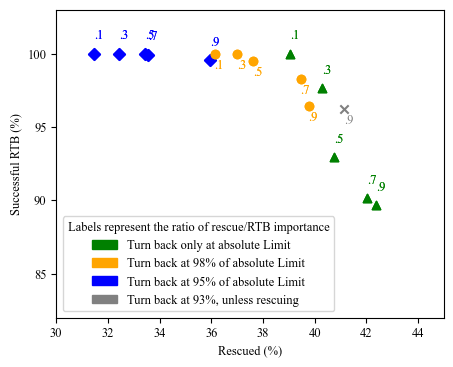

In [20]:
import matplotlib.patches as mpatches

def plot_text_for_points(data,color):
    offset = 1 
    for i, row in data.iloc[::2].iterrows():

        y_offset = (-1) ** i * offset  # Alternate between -offset and +offset
        x_offset = offset  # Alternate between -offset and +offset
        plt.text(100.0*row['Rescued']/MAX_EPISODES, 100.0*row['Success_RTB']/MAX_EPISODES + y_offset, str((row['UTILITARIAN_SEARCH_SUCCESS'])/100.)[1:],color=color)

offset = .5

df_100 = df[df['UTILITARIAN_SAFE_RETURN_FACTOR']==1]
df_95 = df[df['UTILITARIAN_SAFE_RETURN_FACTOR']==.95]
df_98 = df[df['UTILITARIAN_SAFE_RETURN_FACTOR']==.98]
df_93 = df[df['UTILITARIAN_SAFE_RETURN_FACTOR']==.93]
list_93_x = list((100.0*df_93['Rescued']/MAX_EPISODES))
list_93_y = list((100.0*df_93['Success_RTB']/MAX_EPISODES))

print(df_93['Rescued'])

plt.scatter(100.0*df_100['Rescued'].iloc[::2]/MAX_EPISODES, 100.0*df_100['Success_RTB'].iloc[::2]/MAX_EPISODES,color="green",marker="^")
plt.scatter(100.0*df_95['Rescued'].iloc[::2]/MAX_EPISODES, 100.0*df_95['Success_RTB'].iloc[::2]/MAX_EPISODES,color="blue",marker="D")
plt.scatter(100.0*df_98['Rescued'].iloc[::2]/MAX_EPISODES, 100.0*df_98['Success_RTB'].iloc[::2]/MAX_EPISODES,color="orange",marker="o")
plt.scatter((100.0*df_93['Rescued'].iloc[-2]/MAX_EPISODES), (100.0*df_93['Success_RTB'].iloc[-2]/MAX_EPISODES),color="grey",marker="x")
plot_text_for_points(df_100,"green")
plot_text_for_points(df_95,"blue")
#plot_text_for_points(df_93,"grey")
plot_text_for_points(df_98,"orange")
def plot_text_for_points(data,color):
    offset = 1 
    y_offset = (-1) * offset  # Alternate between -offset and +offset
    x_offset = offset  # Alternate between -offset and +offset
    plt.text(100.0*data.iloc[-2]['Rescued']/MAX_EPISODES, 100.0*data.iloc[-2]['Success_RTB']/MAX_EPISODES + y_offset, str((data.iloc[-2]['UTILITARIAN_SEARCH_SUCCESS'])/100.)[1:],color=color)
plot_text_for_points(df_93,"grey")


# for i, row in df_100.iterrows():
#     y_offset = (-1) ** i * offset  # Alternate between -offset and +offset
#     x_offset = offset  # Alternate between -offset and +offset
#     plt.text(100.0*row['Rescued']/MAX_EPISODES, 100.0*row['Success_RTB']/MAX_EPISODES + y_offset, (row['UTILITARIAN_SEARCH_SUCCESS'])/100.,)

plt.xlabel("Rescued (%)")
plt.ylabel("Successful RTB (%)")
plt.xlim(30,45)
plt.ylim(82,103)
plt.yticks([85,90,95,100])

plt.rc('font', size=9, family='serif', serif=['Times New Roman'])

# manually define a new patch 
d100_patch = mpatches.Patch(color='green', label='Turn back only at absolute Limit')
d95_patch = mpatches.Patch(color='blue', label='Turn back at 95% of absolute Limit')
d98_patch = mpatches.Patch(color='orange', label='Turn back at 98% of absolute Limit')
d93_patch = mpatches.Patch(color='grey', label='Turn back at 93%, unless rescuing')
explain_patch = mpatches.Patch(color='grey', label='Labels represent the ratio of rescue/RTB importance')

plt.legend(handles=[d100_patch,d98_patch,d95_patch,d93_patch],title='Labels represent the ratio of rescue/RTB importance')
plt.rc('figure', figsize=(5,4))
plt.savefig('test-save-now-archiving.pdf', dpi=300,bbox_inches='tight')


In [138]:
print_run_params(run_params)

Scenario Variables
***************************************************************
DEFAULT_TIME_STEP :  0.016666666666666666
DEFAULT_SPD :  20
MAX_DISTANCE :  15
MIN_DISTANCE :  5
DEFAULT_FUEL :  48
DEFAULT_FUEL_CONSUMPTION_RATE :  24
DISTANCE_TO_PORT :  20
DEFAULT_RESCUE_ATTEMPTS_BASELINE :  0.0
RESCUE_FUEL_CONSUMPTION_FACTOR :  0.1
FUEL_CONSUMPTION_MAX_VARIATION :  0.0001
SEARCH_FUEL_COST :  1
TRANSIT_FUEL_COST :  0
RESCUE_FUEL_COST :  10
UTILITARIAN_SAFE_RETURN_FACTOR :  0.93
UTILITARIAN_MISSION_SUCCESS :  100
UTILITARIAN_SEARCH_SUCCESS :  100
EXPECTED_SEARCH_SUCCESS :  0.5
EXPECTED_RESCUE_SUCCESS :  0.016666666666666666
***************************************************************


Safe search distance:  10.0
*************************************
DEFAULT_TIME_STEP (min):              1.0 (or  0.016666666666666666 hours)
DEFAULT_SPD (kts):                    20
MAX_DISTANCE (nm):                    15
MIN_DISTANCE (nm):                    5
DEFAULT_FUEL (barrels):               48
DEFAULT_FUEL_CONSUMPTION_RATE (bph):  24
DISTANCE_TO_PORT (nm):                20 (distance from port at which 'man overboard' is detected.
DEFAULT_RESCUE_ATTEMPTS_BASELINE:     0.0 (Adjust the baseline probability of rescue for any timestep
RESCUE_FUEL_CONSUMPTION_FACTOR:       0.1 (The baseline of fuel used in rescue vs. search/transit)
**Fuel consumption variables:**
FUEL_CONSUMPTION_MAX_VARIATION:       5e-05
SEARCH_FUEL_COST:                     1
TRANSIT_FUEL_COST:                    0
RESCUE_FUEL_COST:                     10
*************************************
UTILITARIAN_SAFE_RETURN_FACTOR:       1 (Factor to hedge estimate of safe return distance)
UTILITARIAN_MISSION_SUCCESS:          100
UTILITARIAN_SEARCH_SUCCESS:           10
EXPECTED_SEARCH_SUCCESS:              0.5
EXPECTED_RESCUE_SUCCESS:              0.0167 (Generally set to DEFAULT_TIME_STEP value)
*************************************
Trials:                100000
Number Rescuees Found:  50069        Average found rate:  50.1%
Successful Rescues:     38819        Average rescue rate: 77.5%
Abandoned Rescues:      11250
Total Rescue Time (h):  38944        Average time (min) per rescue attempt: 46.6693
Successful Returns:    100000        Average RTB rate:    100.0%
Average Excess Fuel for Failed Seach & Rescue:   0.000
*************************************
Notes:

Basic run with no extra utilitarian safety and (effectively) no noise in fuel (and no extra costs for search or rescue). In this case, 
*  Reaching port is treated as 10 times the value of the successful rescue
*  Finds roughly half of the men overboard (by design)
*  Takes about 46 min/rescuee to get on board (somehigher than expected, should take on average ~30m)
*  Almost always returns (all RTBs successful here but it can fail)

****************************************************************************************************************************************************

Safe search distance:  10.0
*************************************
UTILITARIAN_MISSION_SUCCESS:          100
UTILITARIAN_SEARCH_SUCCESS:           50
EXPECTED_SEARCH_SUCCESS:              0.5
EXPECTED_RESCUE_SUCCESS:              0.016666666666666666 (Generally set to DEFAULT_TIME_STEP value)
*************************************
Trials:                100000
Number Rescuees Found:  49766        Average found rate:  49.8%
Successful Rescues:     40811        Average rescue rate: 82.0%
Abandoned Rescues:       8955
Total Rescue Time (h):  40854        Average time (min) per rescue attempt: 49.2559
Successful Returns:     93070        Average RTB rate:    93.1%
Average Excess Fuel for Failed Seach & Rescue:   0.000
Average Remaining Distance to Go for Failed RTB: 0.42001
*************************************
Notes:
* Exactly as above except now rescue is weighted at 50% of RTB success
* Marginally improved search and rescue rates (go slightly further, attempt slightly longer rescues)
* Do fail some RTBs (93% success rate)
* Failed RTBs getting to less than .5nm from port (maybe pointing to need to be more flexible about successful RTB?)
****************************************************************************************************************************************************
UTILITARIAN_SEARCH_SUCCESS:           100
*************************************
Trials:                100000
Number Rescuees Found:  49988        Average found rate:  50.0%
Successful Rescues:     43121        Average rescue rate: 86.3%
Abandoned Rescues:       6867
Total Rescue Time (h):  43271        Average time (min) per rescue attempt: 51.9380
Successful Returns:     90087        Average RTB rate:    90.1%
Average Excess Fuel for Failed Seach & Rescue:   0.000
Average Remaining Distance to Go for Failed RTB: 0.74680
*************************************
Notes:
* Rescue is weighted the same as RTB success
* Improved (but not a lot) search and rescue rates (go slightly further, attempt slightly longer rescues)
* Do fail more RTBs (dropped to 90% success rate)
* Failed RTBs getting to just less than .75nm from port

****************************************************************************************************************************************************
Safe search distance:  10.0
*************************************
DEFAULT_TIME_STEP (min):              1.0 (or  0.016666666666666666 hours)
DEFAULT_SPD (kts):                    20
MAX_DISTANCE (nm):                    15
MIN_DISTANCE (nm):                    5
DEFAULT_FUEL (barrels):               48
DEFAULT_FUEL_CONSUMPTION_RATE (bph):  24
DISTANCE_TO_PORT (nm):                20 (distance from port at which 'man overboard' is detected.
DEFAULT_RESCUE_ATTEMPTS_BASELINE:     0.0 (Adjust the baseline probability of rescue for any timestep
RESCUE_FUEL_CONSUMPTION_FACTOR:       0.1 (The baseline of fuel used in rescue vs. search/transit)
**Fuel consumption variables:**
FUEL_CONSUMPTION_MAX_VARIATION:       0.05
SEARCH_FUEL_COST:                     1
TRANSIT_FUEL_COST:                    0
RESCUE_FUEL_COST:                     10
*************************************
UTILITARIAN_SAFE_RETURN_FACTOR:       1 (Factor to hedge estimate of safe return distance)
UTILITARIAN_MISSION_SUCCESS:          100
UTILITARIAN_SEARCH_SUCCESS:           10
EXPECTED_SEARCH_SUCCESS:              0.5
EXPECTED_RESCUE_SUCCESS:              0.016666666666666666 (Generally set to DEFAULT_TIME_STEP value)
*************************************
Trials:                100000
Number Rescuees Found:  46996        Average found rate:  47.0%
Successful Rescues:     36015        Average rescue rate: 76.6%
Abandoned Rescues:      10981
Total Rescue Time (h):  35819        Average time (min) per rescue attempt: 45.7307
Successful Returns:     99969        Average RTB rate:    100.0%
Average Excess Fuel for Failed Seach & Rescue:   0.106
Average Remaining Distance to Go for Failed RTB: 0.33333
*************************************
Notes:
* Same as first run (no fudge factor, 100/10 ratio) but with noisy fuel use (5% variation + extra variation for search and rescue steps)
* Find rate drops (searching takes a bit more fuel so cannot get to 50%)
* Rescue rate is roughly the same (round to 77% in both cases)
* Somewhat shorter rescues: About 1m (one iteration) less time/rescue attempts
* Now see a (very) small number of RTB failures even with 100/10 weighting
* Not a lot of wasted effort here: failed RTBs get to within 2000ft of the port and failed searches end with about 2.5 barrels of fuel remaining

****************************************************************************************************************************************************
Safe search distance:  10.0
*************************************
DEFAULT_TIME_STEP (min):              1.0 (or  0.016666666666666666 hours)
DEFAULT_SPD (kts):                    20
MAX_DISTANCE (nm):                    15
MIN_DISTANCE (nm):                    5
DEFAULT_FUEL (barrels):               48
DEFAULT_FUEL_CONSUMPTION_RATE (bph):  24
DISTANCE_TO_PORT (nm):                20 (distance from port at which 'man overboard' is detected.
DEFAULT_RESCUE_ATTEMPTS_BASELINE:     0.0 (Adjust the baseline probability of rescue for any timestep
RESCUE_FUEL_CONSUMPTION_FACTOR:       0.1 (The baseline of fuel used in rescue vs. search/transit)
**Fuel consumption variables:**
FUEL_CONSUMPTION_MAX_VARIATION:       0.05
SEARCH_FUEL_COST:                     1
TRANSIT_FUEL_COST:                    0
RESCUE_FUEL_COST:                     10
*************************************
UTILITARIAN_SAFE_RETURN_FACTOR:       0.95 (Factor to hedge estimate of safe return distance)
UTILITARIAN_MISSION_SUCCESS:          100
UTILITARIAN_SEARCH_SUCCESS:           10
EXPECTED_SEARCH_SUCCESS:              0.5
EXPECTED_RESCUE_SUCCESS:              0.016666666666666666 (Generally set to DEFAULT_TIME_STEP value)
*************************************
Trials:                100000
Number Rescuees Found:  39945        Average found rate:  39.9%
Successful Rescues:     28604        Average rescue rate: 71.6%
Abandoned Rescues:      11341
Total Rescue Time (h):  28376        Average time (min) per rescue attempt: 42.6228
Successful Returns:    100000        Average RTB rate:    100.0%
Average Excess Fuel for Failed Seach & Rescue:   1.661
*************************************
Notes: 
* This run has 10/100 weighting, noisy fuel, and a .95 SAFE_RETURN factor. Interpret this as "how close to the edge is the captain willing to get"
* Find rate drops 10% because this ship turns back earlier than the previous ones
* Rescue rate drops 5% (risk tolerance leads to 5m shorter rescue attempts)
* No failed missions (safe return tolerance is avoiding getting close to the edge)



In [670]:
def set_parameters(params):
    # Initialize default parameters
    run_params = {
        'DEFAULT_SPD': 20,
        'MAX_DISTANCE': 15,
        'MIN_DISTANCE': 5,
        'DEFAULT_FUEL': 48,
        'DEFAULT_FUEL_CONSUMPTION_RATE': 24,
        'DISTANCE_TO_PORT': 20,
        'DEFAULT_RESCUE_ATTEMPTS_BASELINE': 0.0,
        'RESCUE_FUEL_CONSUMPTION_FACTOR': 0.1,
        'FUEL_CONSUMPTION_MAX_VARIATION': 0.05
    }

    run_params.update(params)
    
    for key,value in run_params.items():
        print(key,value)

my_params_list = [{},{'MAX_DISTANCE':40},{'MAX_DISTANCE':5,'DEFAULT_SPD':25}]
for my_params in my_params_list:
    print("My params",my_params)
    set_parameters(my_params)


My params {}
DEFAULT_SPD 20
MAX_DISTANCE 15
MIN_DISTANCE 5
DEFAULT_FUEL 48
DEFAULT_FUEL_CONSUMPTION_RATE 24
DISTANCE_TO_PORT 20
DEFAULT_RESCUE_ATTEMPTS_BASELINE 0.0
RESCUE_FUEL_CONSUMPTION_FACTOR 0.1
FUEL_CONSUMPTION_MAX_VARIATION 0.05
My params {'MAX_DISTANCE': 40}
DEFAULT_SPD 20
MAX_DISTANCE 40
MIN_DISTANCE 5
DEFAULT_FUEL 48
DEFAULT_FUEL_CONSUMPTION_RATE 24
DISTANCE_TO_PORT 20
DEFAULT_RESCUE_ATTEMPTS_BASELINE 0.0
RESCUE_FUEL_CONSUMPTION_FACTOR 0.1
FUEL_CONSUMPTION_MAX_VARIATION 0.05
My params {'MAX_DISTANCE': 5, 'DEFAULT_SPD': 25}
DEFAULT_SPD 25
MAX_DISTANCE 5
MIN_DISTANCE 5
DEFAULT_FUEL 48
DEFAULT_FUEL_CONSUMPTION_RATE 24
DISTANCE_TO_PORT 20
DEFAULT_RESCUE_ATTEMPTS_BASELINE 0.0
RESCUE_FUEL_CONSUMPTION_FACTOR 0.1
FUEL_CONSUMPTION_MAX_VARIATION 0.05


In [846]:
import itertools

parameters_to_vary = {"UTILITARIAN_SEARCH_SUCCESS":[x for x in range(10,101,10)],
                      "UTILITARIAN_SAFE_RETURN_FACTOR": [0.99, 0.98, 0.95]}

# Create all combinations of the parameters
keys, values = zip(*parameters_to_vary.items())
combinations = [dict(zip(keys, combo)) for combo in itertools.product(*values)]

for params in combinations:
    print(params)

{'UTILITARIAN_SEARCH_SUCCESS': 10, 'UTILITARIAN_SAFE_RETURN_FACTOR': 0.99}
{'UTILITARIAN_SEARCH_SUCCESS': 10, 'UTILITARIAN_SAFE_RETURN_FACTOR': 0.98}
{'UTILITARIAN_SEARCH_SUCCESS': 10, 'UTILITARIAN_SAFE_RETURN_FACTOR': 0.95}
{'UTILITARIAN_SEARCH_SUCCESS': 20, 'UTILITARIAN_SAFE_RETURN_FACTOR': 0.99}
{'UTILITARIAN_SEARCH_SUCCESS': 20, 'UTILITARIAN_SAFE_RETURN_FACTOR': 0.98}
{'UTILITARIAN_SEARCH_SUCCESS': 20, 'UTILITARIAN_SAFE_RETURN_FACTOR': 0.95}
{'UTILITARIAN_SEARCH_SUCCESS': 30, 'UTILITARIAN_SAFE_RETURN_FACTOR': 0.99}
{'UTILITARIAN_SEARCH_SUCCESS': 30, 'UTILITARIAN_SAFE_RETURN_FACTOR': 0.98}
{'UTILITARIAN_SEARCH_SUCCESS': 30, 'UTILITARIAN_SAFE_RETURN_FACTOR': 0.95}
{'UTILITARIAN_SEARCH_SUCCESS': 40, 'UTILITARIAN_SAFE_RETURN_FACTOR': 0.99}
{'UTILITARIAN_SEARCH_SUCCESS': 40, 'UTILITARIAN_SAFE_RETURN_FACTOR': 0.98}
{'UTILITARIAN_SEARCH_SUCCESS': 40, 'UTILITARIAN_SAFE_RETURN_FACTOR': 0.95}
{'UTILITARIAN_SEARCH_SUCCESS': 50, 'UTILITARIAN_SAFE_RETURN_FACTOR': 0.99}
{'UTILITARIAN_SEARCH_SUCC

In [ ]:
MAX_EPISODES = 10
DEFAULT_TIME_STEP = .05 #(15m/quarter of an hr)
found = 0
rtb = 0
safe_search_distance = (DEFAULT_FUEL*DEFAULT_SPD/DEFAULT_FUEL_CONSUMPTION_RATE - DISTANCE_TO_PORT)/2
print("Safe search distance: ", safe_search_distance)
predicted_fuel =[]
actual_fuell=[]

timesteps = 0

for i in range(MAX_EPISODES):

    # Initialize the episode
    
    fuel_remaining = DEFAULT_FUEL
    predicted_fuel_remaining = fuel_remaining
    man_overboard_location = man_overboard()
    #print("Must backtrack: ", save_distance)

    do_search = True
    do_return = False
    search_dist = 0
    rescue_attempts = 0
    return_dist = DISTANCE_TO_PORT
    
    # Assume utilitarian policy for now
    while do_search: 
        timesteps += 1
        # For now, assume a constant speed and 15 min intervals
        search_dist += DEFAULT_SPD*DEFAULT_TIME_STEP
        fuel_remaining -= compute_fuel_consumption("search",DEFAULT_TIME_STEP)
        predicted_fuel_remaining -= DEFAULT_FUEL_CONSUMPTION_RATE*DEFAULT_TIME_STEP
        #print("Fuel: ", fuel_remaining)
        if search_dist >= save_distance:
            if attempt_rescue(rescue_attempts+5):
                found += 1
                do_search = False
                do_return = True
                return_dist = DISTANCE_TO_PORT +save_distance
            else:
                # Failed attempt, keep searching
                # print("Rescue attempt failed...")
                rescue_attempts +=1
        if search_dist >= safe_return_distance(fuel_remaining):
            do_search = False
            do_return = True
            return_dist = DISTANCE_TO_PORT + search_dist

    while do_return:
        timesteps += 1
        #print(return_dist)
        return_dist -= DEFAULT_SPD*DEFAULT_TIME_STEP
        fuel_remaining -= compute_fuel_consumption("transit",DEFAULT_TIME_STEP)
        predicted_fuel_remaining -= DEFAULT_FUEL_CONSUMPTION_RATE*DEFAULT_TIME_STEP
        #print("Return Dist:", return_dist, "Fuel: ", fuel_remaining)

        if return_dist <= 0:
            rtb += 1
            do_return = False
            #print("Sucessful RTB")
        elif fuel_remaining <= 0:
            # Failure
            do_return = False

    #print("Timesteps: ", timesteps, "Actual Fuel Remaining at end: ", fuel_remaining, "Predicted fuel remaining: ", predicted_fuel_remaining)
    timesteps=0

print("Trials:", MAX_EPISODES)
print("Successful Searches: ", found)
print("Successful Returns: ", rtb)